## Modeling

## 1) 📦 Datos y *Data Readiness*

### ✔ Splits utilizados

Los datasets provienen de `data/processed/`, generados tras el wrangling:

| Archivo                    | # Filas | Propósito     |
|---------------------------|--------:|---------------|
| `sentiment_train.parquet` |   3,245 | Entrenamiento |
| `sentiment_val.parquet`   |     696 | Validación    |
| `sentiment_test.parquet`  |     696 | Test final    |

Estos splits fueron generados **antes del modelado**, evitando *data leakage*.

### ✔ Target y métricas

- **Target**: `sentiment` (0 = negativo/bajo, 1 = positivo/alto).  
- Derivada de `score_clipped >= mediana(score_clipped)`.

**Métrica principal**

- **F1-score (binary)** en el conjunto de validación (`val_f1`).

**Métricas secundarias**

- `accuracy` en validación y test.

Se prioriza **F1** porque:

- La distribución de clases es moderadamente desbalanceada (~54% positivos vs ~46% negativos).  
- La *accuracy* puede ocultar errores asimétricos entre clases.  
- F1 combina *precision* y *recall*, penalizando tanto falsos positivos como falsos negativos.  
- En un sistema de sentimiento es importante no sesgarse sistemáticamente hacia una clase.

### ✔ Features utilizadas para modelado

(Ver detalle completo de wrangling en `02_data_wrangling.ipynb`)

| Feature             | Tipo   | Uso actual en modelos            | Razón de inclusión                                |
|---------------------|--------|----------------------------------|---------------------------------------------------|
| `clean_text`        | texto  | **sí** (entrada a modelos NLP)   | contenido principal del comentario                |
| `word_count`        | num    | no (queda disponible)            | proxy de estilo y longitud                        |
| `text_len_clipped`  | num    | no (queda disponible)            | controla outliers de longitud                     |
| `has_exclamation`   | bool   | no (queda disponible)            | señal emocional / énfasis                         |
| `has_question`      | bool   | no (queda disponible)            | tono interrogativo / duda                         |
| `is_submitter`      | bool   | no (queda disponible)            | contexto: autor del post vs comentarista          |
| `score_clipped`     | num    | solo para crear `sentiment`      | evitar usar el score original como feature cruda  |

En esta versión, los modelos se entrenan **solo con el texto limpio**:

- Los BERT consumen directamente `clean_text`.  
- El MLP recibe embeddings densos generados a partir de `clean_text`.

Las demás variables se mantienen disponibles para futuras versiones (modelos híbridos texto + metadata).

### ✔ Prevención de *data leakage*

- La etiqueta `sentiment` se genera antes de definir los splits train/val/test.  
- El cálculo de embeddings y el ajuste del `StandardScaler` se realiza **solo con el conjunto de entrenamiento**.  
- Validación y test se usan únicamente para evaluación; no participan en el entrenamiento ni en el HPO.

---

In [1]:
# 1. Setup general, carga de datos, MLflow y helpers de artefactos (NTBK)

import os, json, warnings
warnings.filterwarnings("ignore")

from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd

import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature

from dotenv import load_dotenv

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer

# === HPO (Hyperopt) ===
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# ----------------------
# Configuración base
# ----------------------
SEED = 42
np.random.seed(SEED)

EXPERIMENT_NAME = "/Users/marianasgg19@gmail.com/EMI/imedia/Sentiment_BERT_MLP"
DEEP_MODEL_NAME = "workspace.default.EMI_imedia_sentiment_deep_model_NTBK"

DATA_DIR = Path("../data/processed")
TRAIN_PATH = DATA_DIR / "sentiment_train.parquet"
VAL_PATH   = DATA_DIR / "sentiment_val.parquet"
TEST_PATH  = DATA_DIR / "sentiment_test.parquet"

assert TRAIN_PATH.exists() and VAL_PATH.exists() and TEST_PATH.exists(), "Faltan splits en data/processed"

train_df = pd.read_parquet(TRAIN_PATH)
val_df   = pd.read_parquet(VAL_PATH)
test_df  = pd.read_parquet(TEST_PATH)

X_train_text = train_df["clean_text"].astype(str).tolist()
X_val_text   = val_df["clean_text"].astype(str).tolist()
X_test_text  = test_df["clean_text"].astype(str).tolist()

y_train = train_df["sentiment"].astype(int).values
y_val   = val_df["sentiment"].astype(int).values
y_test  = test_df["sentiment"].astype(int).values

# ----------------------
# Directorios de artefactos (raíz)
# ----------------------
EMBEDDINGS_DIR = Path("../embeddings")
EMBEDDINGS_DIR.mkdir(parents=True, exist_ok=True)

PREPROC_LOCAL_DIR = Path("../preprocesador")
PREPROC_LOCAL_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------
# Lista global de resultados (para comparar modelos)
# ----------------------
RESULTS = []   # cada entrada: dict con model_key, run_id, val_f1, test_f1, etc.

# ----------------------
# Tracking URI resiliente
# ----------------------
def _resolve_tracking_uri() -> str:
    load_dotenv(override=True)
    env_uri = os.getenv("MLFLOW_TRACKING_URI")
    profile = os.getenv("DATABRICKS_CONFIG_PROFILE")
    host = os.getenv("DATABRICKS_HOST")
    token = os.getenv("DATABRICKS_TOKEN")

    if env_uri:
        return env_uri
    if profile:
        return f"databricks://{profile}"
    if host and token:
        return "databricks"

    local_store = Path.cwd() / "mlruns"
    local_store.mkdir(parents=True, exist_ok=True)
    return f"file://{local_store}"

def set_mlflow():
    tracking_uri = _resolve_tracking_uri()
    mlflow.set_tracking_uri(tracking_uri)
    client = MlflowClient()
    exp = client.get_experiment_by_name(EXPERIMENT_NAME)
    if exp is None:
        client.create_experiment(EXPERIMENT_NAME)
    mlflow.set_experiment(EXPERIMENT_NAME)

set_mlflow()

# ----------------------
# Helper: guardar embeddings como artefacto reproducible (sufijo NTBK)
# ----------------------
import datetime as dt

def save_embeddings_artifact(model_name: str,
                             embeddings_matrix: np.ndarray,
                             split: str,
                             extra_metadata: dict | None = None) -> dict:
    """
    Guarda embeddings + metadata en ../embeddings con sufijo NTBK.
    """
    safe_model_name = model_name.replace("/", "_")
    timestamp = dt.datetime.utcnow().strftime("%Y%m%dT%H%M%S")

    base_name = f"{safe_model_name}_{split}_{timestamp}_NTBK"

    emb_path = EMBEDDINGS_DIR / f"{base_name}_embeddings.npy"
    meta_path = EMBEDDINGS_DIR / f"{base_name}_metadata.json"

    np.save(emb_path, embeddings_matrix)

    metadata = {
        "model_name": model_name,
        "split": split,
        "embedding_shape": embeddings_matrix.shape,
        "created_utc": dt.datetime.utcnow().isoformat() + "Z",
    }
    if extra_metadata:
        metadata.update(extra_metadata)

    pd.Series(metadata).to_json(meta_path)

    return {
        "embeddings_path": str(emb_path),
        "metadata_path": str(meta_path),
    }


In [2]:
# 2. Dos modelos BERT para clasificación directa de sentimiento + MLflow + guardado de tokenizers (preprocesador/)

from scipy.special import softmax
import torch

BERT_MODELS = [
    "nlptown/bert-base-multilingual-uncased-sentiment",      # 5 clases (1-5 stars)
    "distilbert-base-uncased-finetuned-sst-2-english",       # 2 clases (neg/pos)
]

def predict_binary_from_logits(logits: np.ndarray, model_name: str) -> int:
    """
    Convierte logits de cada modelo a etiqueta binaria 0/1.
    Implementación simple basada en convenciones típicas de estos checkpoints.
    """
    probs = softmax(logits)[0]
    if "nlptown" in model_name:
        # 5 clases -> 1,2 = negativo; 3 = neutro; 4,5 = positivo
        idx = np.argmax(probs)
        return 1 if idx >= 3 else 0
    else:
        # Modelos binarios: índice 1 = positivo
        idx = np.argmax(probs)
        return 1 if idx == 1 else 0

def run_bert_model(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    def predict_batch(texts):
        preds = []
        for t in texts:
            inputs = tokenizer(
                t,
                return_tensors="pt",
                truncation=True,
                padding=True,
                max_length=256,
            )
            with torch.no_grad():
                logits = model(**inputs).logits.numpy()
            preds.append(predict_binary_from_logits(logits, model_name))
        return np.array(preds, dtype=int)

    with mlflow.start_run(run_name=f"BERT_{model_name.split('/')[-1]}") as run:
        y_val_pred = predict_batch(X_val_text)
        y_test_pred = predict_batch(X_test_text)

        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1  = f1_score(y_val, y_val_pred, average="binary")
        test_acc = accuracy_score(y_test, y_test_pred)
        test_f1  = f1_score(y_test, y_test_pred, average="binary")

        mlflow.log_param("model_family", "bert_sequence_classifier")
        mlflow.log_param("hf_model_name", model_name)
        mlflow.log_metric("val_accuracy", val_acc)
        mlflow.log_metric("val_f1",       val_f1)
        mlflow.log_metric("test_accuracy", test_acc)
        mlflow.log_metric("test_f1",       test_f1)

        print(f"\n=== {model_name} ===")
        print("Validation accuracy:", val_acc)
        print("Validation F1      :", val_f1)
        print("Test accuracy      :", test_acc)
        print("Test F1            :", test_f1)

        # Guardar tokenizer como "preprocesador" en raíz/preprocesador con sufijo NTBK
        safe_name = model_name.replace("/", "_")
        ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
        tok_dir = PREPROC_LOCAL_DIR / f"{safe_name}_tokenizer_NTBK_{ts}"
        tok_dir.mkdir(parents=True, exist_ok=True)
        tokenizer.save_pretrained(tok_dir)

        # Loggear tokenizer como artifact en MLflow
        mlflow.log_artifacts(str(tok_dir), artifact_path="preprocessor_tokenizer")

        # ---> Guardar resultados en la tabla global RESULTS
        RESULTS.append({
            "model_key": f"bert_{model_name.split('/')[-1]}",
            "run_id": run.info.run_id,
            "val_accuracy": float(val_acc),
            "val_f1": float(val_f1),
            "test_accuracy": float(test_acc),
            "test_f1": float(test_f1),
        })

for m_name in BERT_MODELS:
    run_bert_model(m_name)



=== nlptown/bert-base-multilingual-uncased-sentiment ===
Validation accuracy: 0.46120689655172414
Validation F1      : 0.3902439024390244
Test accuracy      : 0.4454022988505747
Test F1            : 0.3713355048859935
🏃 View run BERT_bert-base-multilingual-uncased-sentiment at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355/runs/bac954c7cfb2435b80ccba1d554cdd4e
🧪 View experiment at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355

=== distilbert-base-uncased-finetuned-sst-2-english ===
Validation accuracy: 0.4367816091954023
Validation F1      : 0.35737704918032787
Test accuracy      : 0.4238505747126437
Test F1            : 0.3500810372771475
🏃 View run BERT_distilbert-base-uncased-finetuned-sst-2-english at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355/runs/b14e371bb1e744999040098720fb25bc
🧪 View experiment at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/169098070495635

---
## 2) 🧱 Preprocesamiento y Pipelines

Se adoptan dos estrategias de representación del texto:

---

### 2.1 BERT (clasificación directa)

**Modelos usados**

- `nlptown/bert-base-multilingual-uncased-sentiment` (5 clases, 1–5 estrellas).  
- `distilbert-base-uncased-finetuned-sst-2-english` (2 clases, neg/pos).

**Preprocesamiento**

- Tokenización con `AutoTokenizer` (padding, truncation, `max_length=256`).  
- Inferencia con `AutoModelForSequenceClassification` sin *fine-tuning* adicional.

**Conversión a etiqueta binaria**

- `nlptown` (5 clases):
  - 1–2 → negativo  
  - 3 → neutro (se agrupa según la probabilidad máxima)  
  - 4–5 → positivo
- `distilbert-sst2`:
  - se usa directamente la clase positiva/negativa predicha.

Los *tokenizers* de ambos modelos se guardan como **preprocesadores versionados** en `../preprocesador/` y se loggean como artefactos en MLflow.

---

### 2.2 SentenceTransformer + StandardScaler + MLP

Se construye un pipeline clásico sobre embeddings:

```text
clean_text
 └──► SentenceTransformer (MiniLM-L6-v2 → embedding 384-d)   [fuera del pipeline sklearn]
       └──► StandardScaler (with_mean, with_std)            [ajustado solo con train]
             └──► MLPClassifier (capa oculta, ReLU, Adam)
```

- Los embeddings se calculan una sola vez por split y se guardan en ../embeddings/ junto con metadata (modelo usado, forma, timestamp).

- El pipeline StandardScaler + MLPClassifier se serializa con MLflow y se registra en el Model Registry.

**Reproducibilidad**

- SEED = 42 fijado en NumPy y en MLPClassifier.

- El tracking URI de MLflow se resuelve de forma robusta (perfil de Databricks o backend local).

- Los artefactos se nombran con sufijo _NTBK y timestamp para trazabilidad.

---

In [6]:
# 3. SentenceTransformer embeddings + MLPClassifier + HPO (Hyperopt) + registro en Model Registry
#    + comparación entre los 3 modelos y asignación de alias 'champion' si el mejor es el MLP

from mlflow import sklearn as mlflow_sklearn

# ---------------------------
# Embeddings con SentenceTransformer
# ---------------------------
st_model_name = "sentence-transformers/all-MiniLM-L6-v2"
st_model = SentenceTransformer(st_model_name)

def embed_texts(model, texts, batch_size=32):
    texts = list(texts)
    emb = model.encode(
        texts,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
    )
    return emb

# ---- Embeddings para cada split (solo una vez) ----
X_train_emb = embed_texts(st_model, X_train_text)
X_val_emb   = embed_texts(st_model, X_val_text)
X_test_emb  = embed_texts(st_model, X_test_text)

print("Emb shapes:", X_train_emb.shape, X_val_emb.shape, X_test_emb.shape)

# Guardar embeddings como artefactos NTBK en ../embeddings
emb_info_train = save_embeddings_artifact(st_model_name, X_train_emb, split="train")
emb_info_val   = save_embeddings_artifact(st_model_name, X_val_emb,   split="val")
emb_info_test  = save_embeddings_artifact(st_model_name, X_test_emb,  split="test")

# ---------------------------
# HPO con Hyperopt sobre el MLP
# ---------------------------

# Listas de opciones para hp.choice
HLS_CHOICES      = [(128,), (256,), (512,)]
BS_CHOICES       = [64, 128, 256]
MAXITER_CHOICES  = [5, 10, 20]

search_space = {
    # hp.choice devuelve el ÍNDICE dentro de la lista; luego mapeamos
    "hidden_layer_sizes": hp.choice("hidden_layer_sizes", HLS_CHOICES),
    "alpha": hp.loguniform("alpha", np.log(1e-5), np.log(1e-1)),
    "learning_rate_init": hp.loguniform("learning_rate_init", np.log(1e-4), np.log(5e-3)),
    "batch_size": hp.choice("batch_size", BS_CHOICES),
    "max_iter": hp.choice("max_iter", MAXITER_CHOICES),
}

def objective(params):
    """
    Función objetivo para Hyperopt.
    Entrena pipeline scaler + MLP con los hiperparámetros propuestos
    y devuelve -val_f1 (porque Hyperopt MINIMIZA).
    """
    mlp_clf = MLPClassifier(
        hidden_layer_sizes=params["hidden_layer_sizes"],
        activation="relu",
        solver="adam",
        batch_size=int(params["batch_size"]),
        learning_rate_init=float(params["learning_rate_init"]),
        alpha=float(params["alpha"]),
        max_iter=int(params["max_iter"]),
        random_state=SEED,
        verbose=False,
    )

    pipe = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("mlp", mlp_clf),
    ])

    with mlflow.start_run(run_name="mlp_hpo_trial", nested=True) as trial_run:
        pipe.fit(X_train_emb, y_train)

        y_val_pred = pipe.predict(X_val_emb)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_f1  = f1_score(y_val, y_val_pred, average="binary")

        # Log de hiperparámetros y métricas de este trial
        mlflow.log_param("model_family", "mlp_classifier")
        mlflow.log_param("features", "sentence_transformers_embeddings")
        mlflow.log_params({
            "hidden_layer_sizes": params["hidden_layer_sizes"],
            "alpha": params["alpha"],
            "learning_rate_init": params["learning_rate_init"],
            "batch_size": params["batch_size"],
            "max_iter": params["max_iter"],
        })
        mlflow.log_metric("val_accuracy", val_acc)
        mlflow.log_metric("val_f1", val_f1)

        return {
            "loss": -val_f1,   # queremos maximizar F1 → minimizamos -F1
            "status": STATUS_OK,
        }

# ---------------------------
# Parent run de HPO + entrenamiento final del mejor modelo
# ---------------------------
MAX_EVALS = 20  # ajusta según tu presupuesto

with mlflow.start_run(run_name="mlp_transformer_embeddings_HPO_NTBK") as run:

    trials = Trials()
    best = fmin(
        fn=objective,
        space=search_space,
        algo=tpe.suggest,
        max_evals=MAX_EVALS,
        trials=trials,
        # USAR Generator (tiene .integers); antes era RandomState
        rstate=np.random.default_rng(SEED),
    )

    # Como usamos hp.choice, Hyperopt guarda los ÍNDICES;
    # hay que mapear de vuelta a las listas originales:
    idx_hls      = best["hidden_layer_sizes"]
    idx_batch    = best["batch_size"]
    idx_max_iter = best["max_iter"]

    best_hls      = HLS_CHOICES[idx_hls]
    best_batch    = BS_CHOICES[idx_batch]
    best_max_iter = MAXITER_CHOICES[idx_max_iter]

    best_alpha = best["alpha"]
    best_lr    = best["learning_rate_init"]

    # Loggear best params al parent run
    mlflow.log_param("hpo_max_evals", MAX_EVALS)
    mlflow.log_params({
        "best_hidden_layer_sizes": best_hls,
        "best_alpha": best_alpha,
        "best_learning_rate_init": best_lr,
        "best_batch_size": best_batch,
        "best_max_iter": best_max_iter,
    })

    # ------------------------------------------------
    # Entrenamiento final del MLP con hiperparámetros óptimos
    # ------------------------------------------------
    best_mlp = MLPClassifier(
        hidden_layer_sizes=best_hls,
        activation="relu",
        solver="adam",
        batch_size=int(best_batch),
        learning_rate_init=float(best_lr),
        alpha=float(best_alpha),
        max_iter=int(best_max_iter),
        random_state=SEED,
        verbose=True,
    )

    best_pipe = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=True)),
        ("mlp", best_mlp),
    ])

    best_pipe.fit(X_train_emb, y_train)

    # Evaluación final en val y test
    y_val_pred  = best_pipe.predict(X_val_emb)
    y_test_pred = best_pipe.predict(X_test_emb)

    val_acc = accuracy_score(y_val, y_val_pred)
    val_f1  = f1_score(y_val, y_val_pred, average="binary")
    test_acc = accuracy_score(y_test, y_test_pred)
    test_f1  = f1_score(y_test, y_test_pred, average="binary")

    print("\n[FINAL MLP + Transformer después de HPO]")
    print("Validation accuracy:", val_acc)
    print("Validation F1      :", val_f1)
    print("Test accuracy      :", test_acc)
    print("Test F1            :", test_f1)

    # Log de métricas finales en el parent run
    mlflow.log_metric("final_val_accuracy",  val_acc)
    mlflow.log_metric("final_val_f1",        val_f1)
    mlflow.log_metric("final_test_accuracy", test_acc)
    mlflow.log_metric("final_test_f1",       test_f1)

    # Log de embeddings como artifacts de MLflow (solo una vez)
    mlflow.log_artifact(emb_info_train["embeddings_path"], artifact_path="embeddings/train")
    mlflow.log_artifact(emb_info_val["embeddings_path"],   artifact_path="embeddings/val")
    mlflow.log_artifact(emb_info_test["embeddings_path"],  artifact_path="embeddings/test")

    # Firma del modelo
    example_input = X_train_emb[:100]
    example_output = best_pipe.predict(example_input)
    signature = infer_signature(example_input, example_output)

    # --- Registry: Unity Catalog (nombre DEEP_MODEL_NAME ya es 3-niveles) ---
    mlflow.set_registry_uri("databricks-uc")

    mlflow_sklearn.log_model(
        sk_model=best_pipe,
        artifact_path="model",
        registered_model_name=DEEP_MODEL_NAME,
        signature=signature,
        input_example=example_input[:5],
    )

    # Guardar PREPROCESADOR (scaler) localmente con sufijo NTBK
    fitted_scaler = best_pipe.named_steps["scaler"]
    ts = datetime.utcnow().strftime("%Y%m%d_%H%M%S")
    local_preproc_dir = PREPROC_LOCAL_DIR / f"mlp_scaler_NTBK_{ts}"
    mlflow_sklearn.save_model(sk_model=fitted_scaler, path=str(local_preproc_dir))

    # Loggear también el preprocesador como artifact
    mlflow_sklearn.log_model(
        sk_model=fitted_scaler,
        artifact_path="preprocessor_scaler_NTBK",
    )

    # ---> Guardar resultados del MLP en la tabla global RESULTS
    RESULTS.append({
        "model_key": "mlp_transformer",
        "run_id": run.info.run_id,
        "val_accuracy": float(val_acc),
        "val_f1": float(val_f1),
        "test_accuracy": float(test_acc),
        "test_f1": float(test_f1),
    })

# ==========================
# Comparativa entre modelos
# ==========================
results_df = pd.DataFrame(RESULTS).sort_values("val_f1", ascending=False).reset_index(drop=True)
print("\n=== Comparación de modelos por val_f1 (desc) ===")
print(results_df)

best_row = results_df.iloc[0]
best_model_key = best_row["model_key"]
print(f"\n🏆 Mejor modelo según val_f1: {best_model_key} (val_f1={best_row['val_f1']:.4f})")

# ==========================
# Alias 'champion' en UC SOLO si el mejor es el MLP
# ==========================
from mlflow import MlflowClient

if best_model_key == "mlp_transformer":
    mlflow.set_registry_uri("databricks-uc")
    client = MlflowClient()

    versions = client.search_model_versions(f"name = '{DEEP_MODEL_NAME}'")

    if versions:
        champ_version = max(int(v.version) for v in versions)
        client.set_registered_model_alias(
            name=DEEP_MODEL_NAME,
            alias="champion",
            version=champ_version,
        )
        print(f"\n✅ Alias 'champion' asignado a {DEEP_MODEL_NAME} (v{champ_version})")
    else:
        print(f"\n⚠ No se encontraron versiones para el modelo {DEEP_MODEL_NAME}")
else:
    print("\n⚠ El mejor modelo es un BERT (no registrado en UC en este notebook).")
    print("   El MLP se registró en el Model Registry, pero SIN alias 'champion'.")


Batches:   0%|          | 0/102 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Emb shapes: (3245, 384) (696, 384) (696, 384)
🏃 View run mlp_hpo_trial at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355/runs/de5fcc9d6b464b5ea1cb8295a22d4233

🧪 View experiment at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355

🏃 View run mlp_hpo_trial at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355/runs/e1d3112f879b415888239ce24f71af49

🧪 View experiment at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355

🏃 View run mlp_hpo_trial at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355/runs/aa414d8cd7704673a0c94f8ac6f808ac

🧪 View experiment at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355

🏃 View run mlp_hpo_trial at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355/runs/4e602a37643446b392638ebc67baeabc

🧪 View experiment at: https://dbc-5922e233-b716.cloud.databr

2025/12/02 16:40:15 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025/12/02 16:40:18 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after p

Uploading artifacts:   0%|          | 0/8 [00:00<?, ?it/s]

Created version '5' of model 'workspace.default.emi_imedia_sentiment_deep_model_ntbk'.
2025/12/02 16:40:31 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2025/12/02 16:40:32 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/12/02 16:40:32 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/12/02 16:40:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
huggingface/tokenizers: The current process just got forked, after para

🏃 View run mlp_transformer_embeddings_HPO_NTBK at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355/runs/f5dae0c48aef4c82a8a1cfd77f3af4b2
🧪 View experiment at: https://dbc-5922e233-b716.cloud.databricks.com/ml/experiments/1690980704956355

=== Comparación de modelos por val_f1 (desc) ===
                                           model_key  \
0                                    mlp_transformer   
1      bert_bert-base-multilingual-uncased-sentiment   
2  bert_distilbert-base-uncased-finetuned-sst-2-e...   

                             run_id  val_accuracy    val_f1  test_accuracy  \
0  f5dae0c48aef4c82a8a1cfd77f3af4b2      0.683908  0.714286       0.685345   
1  bac954c7cfb2435b80ccba1d554cdd4e      0.461207  0.390244       0.445402   
2  b14e371bb1e744999040098720fb25bc      0.436782  0.357377       0.423851   

    test_f1  
0  0.709163  
1  0.371336  
2  0.350081  

🏆 Mejor modelo según val_f1: mlp_transformer (val_f1=0.7143)

✅ Alias 'champion' asign


---

## 3) 🧪 Familias de modelos entrenadas

En total se entrenan y registran **tres modelos**:

1. **`bert_bert-base-multilingual-uncased-sentiment`**  
   - *Familia*: `bert_sequence_classifier` multilingüe.  
   - Funcionamiento:
     - Entrada: `clean_text`.  
     - Tokenización → BERT → logits de 5 clases → `softmax` → mapeo a etiqueta binaria.  
   - Validación:
     - Se calculan `val_accuracy`, `val_f1`, `test_accuracy`, `test_f1`.  
     - Se loggean en MLflow junto con el `hf_model_name` y el *tokenizer* como artefacto.

2. **`bert_distilbert-base-uncased-finetuned-sst-2-english`**  
   - *Familia*: `bert_sequence_classifier` compacto.  
   - Funcionamiento análogo, pero la cabeza de clasificación es directamente binaria (neg/pos).  
   - Tiene menor costo computacional y latencia que el BERT multilingüe.

3. **`mlp_transformer` (SentenceTransformer + MLPClassifier)**  
   - *Familia*: `mlp_classifier + sentence_transformer`.  
   - Funcionamiento:
     - `clean_text` → embeddings MiniLM-L6-v2 de 384 dimensiones.  
     - Embeddings → `StandardScaler`.  
     - Escalado → `MLPClassifier` entrenado con hiperparámetros ajustados vía HPO.  
   - Validación:
     - Métricas loggeadas: `val_accuracy`, `val_f1`, `test_accuracy`, `test_f1`.  
     - Se registra el pipeline completo (scaler + MLP) en Unity Catalog.

En todos los casos se mantiene el mismo esquema de evaluación:

- **Train**: ajuste de parámetros / hiperparámetros.  
- **Validation**: comparación y selección de modelo según `val_f1`.  
- **Test**: estimación final de desempeño, sin usar para tomar decisiones de entrenamiento.

---

## 4) 🎯 HPO (Hyperparameter Optimization) con Hyperopt + MLflow

El ajuste de hiperparámetros se aplica sobre el modelo **`mlp_transformer`**, dado que es el mas complejo y de hecho el que mejor se comporta.

### 4.1 Espacio de búsqueda

Se define un espacio de búsqueda con **Hyperopt**:

- `hidden_layer_sizes` ∈ {(128,), (256,), (512,)}  
- `alpha` ∼ loguniform(1e-5, 1e-1)  
- `learning_rate_init` ∼ loguniform(1e-4, 5e-3)  
- `batch_size` ∈ {64, 128, 256}  
- `max_iter` ∈ {5, 10, 20}

### 4.2 Función objetivo

La función objetivo entrena un pipeline `StandardScaler + MLPClassifier` con los parámetros propuestos y devuelve:

- `loss = -val_f1` (Hyperopt minimiza → se maximiza F1 en validación).

Cada evaluación se ejecuta en un run anidado de MLflow con nombre `mlp_hpo_trial`, donde se loggean:

- hiperparámetros del trial,  
- `val_accuracy` y `val_f1`.

### 4.3 Parent run y mejores hiperparámetros

Las búsquedas se agrupan bajo un **parent run**:

- `mlp_transformer_embeddings_HPO_NTBK`

Desde los trials registrados se recuperan los **mejores hiperparámetros**, por ejemplo:

- `hidden_layer_sizes = (256,)`  
- `alpha ≈ 3e-4`  
- `learning_rate_init ≈ 1e-3`  
- `batch_size = 256`  
- `max_iter = 10`

Con esos valores se reentrena el pipeline completo sobre el conjunto de entrenamiento, y se evalúa en `val` y `test`.  
Las métricas finales se loggean en el parent run como:

- `final_val_accuracy`, `final_val_f1`,  
- `final_test_accuracy`, `final_test_f1`.

---

In [8]:
# 4. Comparación consolidada y justificación final de modelos (visual + texto)

import plotly.express as px

# ---------------------------
# Construir tabla consolidada
# ---------------------------
comp_df = pd.DataFrame(RESULTS).copy()

# Añadir familia e hiperparámetros clave (a partir de model_key)
def enrich_row(row):
    mk = row["model_key"]

    if "bert-base-multilingual-uncased-sentiment" in mk:
        family = "bert_sequence_classifier"
        hyper = "hf_model=nlptown/bert-base-multilingual-uncased-sentiment"
        cost = "alto (modelo grande, multilingüe)"
        latency = "media-alta"

    elif "distilbert-base-uncased-finetuned-sst-2-english" in mk:
        family = "bert_sequence_classifier"
        hyper = "hf_model=distilbert-base-uncased-finetuned-sst-2-english"
        cost = "medio (modelo compacto)"
        latency = "media"

    elif mk == "mlp_transformer":
        family = "mlp_classifier + sentence_transformer"
        hyper = "ST=all-MiniLM-L6-v2, hidden=(256,), max_iter=10"
        cost = "medio (embeddings + MLP)"
        latency = "baja-media (si embeddings precalculados)"

    else:
        family = "desconocido"
        hyper = ""
        cost = ""
        latency = ""

    return pd.Series({
        "family": family,
        "hyperparams": hyper,
        "cost_prod": cost,
        "latency_prod": latency,
    })


extra_cols = comp_df.apply(enrich_row, axis=1)
comp_df = pd.concat([comp_df, extra_cols], axis=1)

# Señales simples de overfitting: gap entre val y test
comp_df["gap_f1_val_test"] = comp_df["val_f1"] - comp_df["test_f1"]
comp_df["gap_acc_val_test"] = comp_df["val_accuracy"] - comp_df["test_accuracy"]

# Ordenar por val_f1 desc
comp_df = comp_df.sort_values("val_f1", ascending=False).reset_index(drop=True)

print("=== Tabla consolidada de modelos (ordenada por val_f1 desc) ===")
display(comp_df[[
    "model_key", "family", "hyperparams",
    "val_accuracy", "val_f1", "test_accuracy", "test_f1",
    "gap_f1_val_test", "gap_acc_val_test",
    "cost_prod", "latency_prod"
]])

# ---------------------------
# Visualizaciones
# ---------------------------

# 1) Barras de F1 (validación y test) por modelo
long_f1 = comp_df.melt(
    id_vars=["model_key"],
    value_vars=["val_f1", "test_f1"],
    var_name="split",
    value_name="f1_score"
)

fig_f1 = px.bar(
    long_f1,
    x="model_key",
    y="f1_score",
    color="split",
    barmode="group",
    title="F1-score por modelo (validación vs test)",
)
fig_f1.show()

# 2) Barras de accuracy (validación y test) por modelo
long_acc = comp_df.melt(
    id_vars=["model_key"],
    value_vars=["val_accuracy", "test_accuracy"],
    var_name="split",
    value_name="accuracy"
)

fig_acc = px.bar(
    long_acc,
    x="model_key",
    y="accuracy",
    color="split",
    barmode="group",
    title="Accuracy por modelo (validación vs test)",
)
fig_acc.show()

# 3) Scatter val_f1 vs test_f1 para ver estabilidad
fig_scatter = px.scatter(
    comp_df,
    x="val_f1",
    y="test_f1",
    text="model_key",
    title="Val F1 vs Test F1 (estabilidad de desempeño)",
)
fig_scatter.update_traces(textposition="top center")
fig_scatter.show()

# ---------------------------
# Justificación final (texto)
# ---------------------------
best_row = comp_df.iloc[0]
best_model = best_row["model_key"]
best_family = best_row["family"]

print("\n=== Justificación final de modelo recomendado ===\n")
print(f"- Modelo con mejor F1 en validación: {best_model} "
      f"(val_f1={best_row['val_f1']:.4f}, test_f1={best_row['test_f1']:.4f})")
print(f"- Familia de modelo: {best_family}")
print(f"- Hiperparámetros clave: {best_row['hyperparams']}")
print(f"- Coste en producción (cualitativo): {best_row['cost_prod']}")
print(f"- Latencia esperada (cualitativa): {best_row['latency_prod']}")

gap_f1 = best_row["gap_f1_val_test"]
print(f"- Gap F1 val-test: {gap_f1:.4f} "
      "(positivo grande podría indicar overfitting).")

# Comentario de overfitting básico
if abs(gap_f1) < 0.02:
    print("  · Señal: el gap val-test es pequeño → desempeño estable, poco overfitting.")
elif gap_f1 > 0.05:
    print("  · Señal: el F1 en validación es bastante mejor que en test → posible overfitting.")
else:
    print("  · Señal: hay un gap moderado, revisar si es aceptable según el caso de uso.")




=== Tabla consolidada de modelos (ordenada por val_f1 desc) ===


,model_key,family,hyperparams,val_accuracy,val_f1,test_accuracy,test_f1,gap_f1_val_test,gap_acc_val_test,cost_prod,latency_prod
0,mlp_transformer,mlp_classifier + sentence_transformer,"ST=all-MiniLM-L6-v2, hidden=(256,), max_iter=10",0.683908,0.714286,0.685345,0.709163,0.005122,-0.001437,medio (embeddings + MLP),baja-media (si embeddings precalculados)
1,bert_bert-base-multilingual-uncased-sentiment,bert_sequence_classifier,hf_model=nlptown/bert-base-multilingual-uncase...,0.461207,0.390244,0.445402,0.371336,0.018908,0.015805,"alto (modelo grande, multilingüe)",media-alta
2,bert_distilbert-base-uncased-finetuned-sst-2-e...,bert_sequence_classifier,hf_model=distilbert-base-uncased-finetuned-sst...,0.436782,0.357377,0.423851,0.350081,0.007296,0.012931,medio (modelo compacto),media



=== Justificación final de modelo recomendado ===

- Modelo con mejor F1 en validación: mlp_transformer (val_f1=0.7143, test_f1=0.7092)
- Familia de modelo: mlp_classifier + sentence_transformer
- Hiperparámetros clave: ST=all-MiniLM-L6-v2, hidden=(256,), max_iter=10
- Coste en producción (cualitativo): medio (embeddings + MLP)
- Latencia esperada (cualitativa): baja-media (si embeddings precalculados)
- Gap F1 val-test: 0.0051 (positivo grande podría indicar overfitting).
  · Señal: el gap val-test es pequeño → desempeño estable, poco overfitting.


## 5) 🏆 Comparación de modelos

A partir de la lista global `RESULTS` se construye una tabla consolidada con:

- `model_key`, `family`, `hyperparams`.  
- `val_accuracy`, `val_f1`, `test_accuracy`, `test_f1`.  
- Gaps de posible overfitting: `gap_f1_val_test`, `gap_acc_val_test`.  
- Apreciación cualitativa de costo y latencia en producción.

Resultados agregados:

| model_key                                               | family                                   | val_f1 | test_f1 | cost_prod                         | latency_prod                             |
|--------------------------------------------------------|------------------------------------------|-------:|--------:|-----------------------------------|------------------------------------------|
| **mlp_transformer**                                    | mlp_classifier + sentence_transformer    | **0.714** | **0.709** | medio (embeddings + MLP)         | baja–media (si embeddings precalculados) |
| bert_bert-base-multilingual-uncased-sentiment          | bert_sequence_classifier                 | 0.390 | 0.371   | alto (modelo grande, multilingüe) | media–alta                               |
| bert_distilbert-base-uncased-finetuned-sst-2-english   | bert_sequence_classifier                 | 0.357 | 0.350   | medio (modelo compacto)           | media                                    |

El gap `val_f1 - test_f1` del MLP es ≈ **0.005**, señal de desempeño **muy estable**.

### Visualizaciones incluidas

- **Barras de F1 (val/test)** por modelo.  
- **Barras de accuracy (val/test)** por modelo.  
- **Scatter `val_f1` vs `test_f1`** para ver estabilidad.

En todas ellas el modelo `mlp_transformer` domina claramente a los BERTs baselines.

## 6) 🥇 Modelo ganador y explicación técnica

### 6.1 Modelo seleccionado

El criterio de selección es **maximizar F1 en validación (`val_f1`)**:

- **Modelo ganador**: `mlp_transformer`  
- `val_f1 = 0.7143`  
- `test_f1 = 0.7092`  
- `gap_f1_val_test ≈ 0.005` → desempeño estable, sin señales fuertes de overfitting.

### 6.2 Por qué este modelo y cómo funciona

- Los modelos BERT se usan como **baselines de inferencia**, sin *fine-tuning* sobre nuestros datos.  
- El dataset contiene texto conversacional, slang y ruido; en este contexto, las representaciones densas de **MiniLM + un MLP especializado** capturan mejor las señales de sentimiento que un BERT genérico sin reentrenar.
- El MLP es sencillo de entrenar, fácil de monitorizar y admite HPO sistemático.

**Resumen de funcionamiento del modelo ganador**

1. `clean_text` → embeddings con `sentence-transformers/all-MiniLM-L6-v2`.  
2. Embeddings → `StandardScaler` (ajustado con train).  
3. Escalado → `MLPClassifier` (hidden layer (256,), ReLU, Adam, hiperparámetros ajustados vía Hyperopt).  
4. Salida: probabilidad de clase positiva → etiqueta binaria `sentiment`.

### 6.3 Métrica F1 como eje de evaluación

Se mantiene F1 como métrica central porque:

- resume la calidad del modelo en una única cifra robusta a leves desbalances;
- penaliza tanto FP como FN, lo que es clave cuando el mismo sistema puede alimentar dashboards, alertas o decisiones de producto de contenido;
- en la práctica observamos que modelos con mayor accuracy pero menor F1 cometían errores de sesgo hacia una clase.

## 7) 🗂️ Registro del modelo en Unity Catalog

El pipeline ganador se registra bajo el nombre:

```text
workspace.default.EMI_imedia_sentiment_deep_model_NTBK
```

Elementos registrados:

- Pipeline StandardScaler + MLPClassifier serializado con MLflow.

- Firma del modelo (signature) e input_example para facilitar el despliegue.

- Artefactos de embeddings y del preprocesador (scaler_NTBK_*).

- Runs anidados de HPO asociados al experimento Sentiment_BERT_MLP.

Dado que el mejor modelo es el MLP, se asigna el alias:

- alias = "champion"

- versión actual.

## 8) 📌 Conclusión

El modelo SentenceTransformer + MLP ajustado con HPO ofrece el mejor equilibrio entre F1, estabilidad, coste computacional y latencia, superando ampliamente a los BERTs utilizados solo en modo inferencia.
Gracias a la integración con MLflow y Unity Catalog, el pipeline es totalmente reproducible, auditable y listo para ser desplegado en un entorno de producción o de experimentación continua.

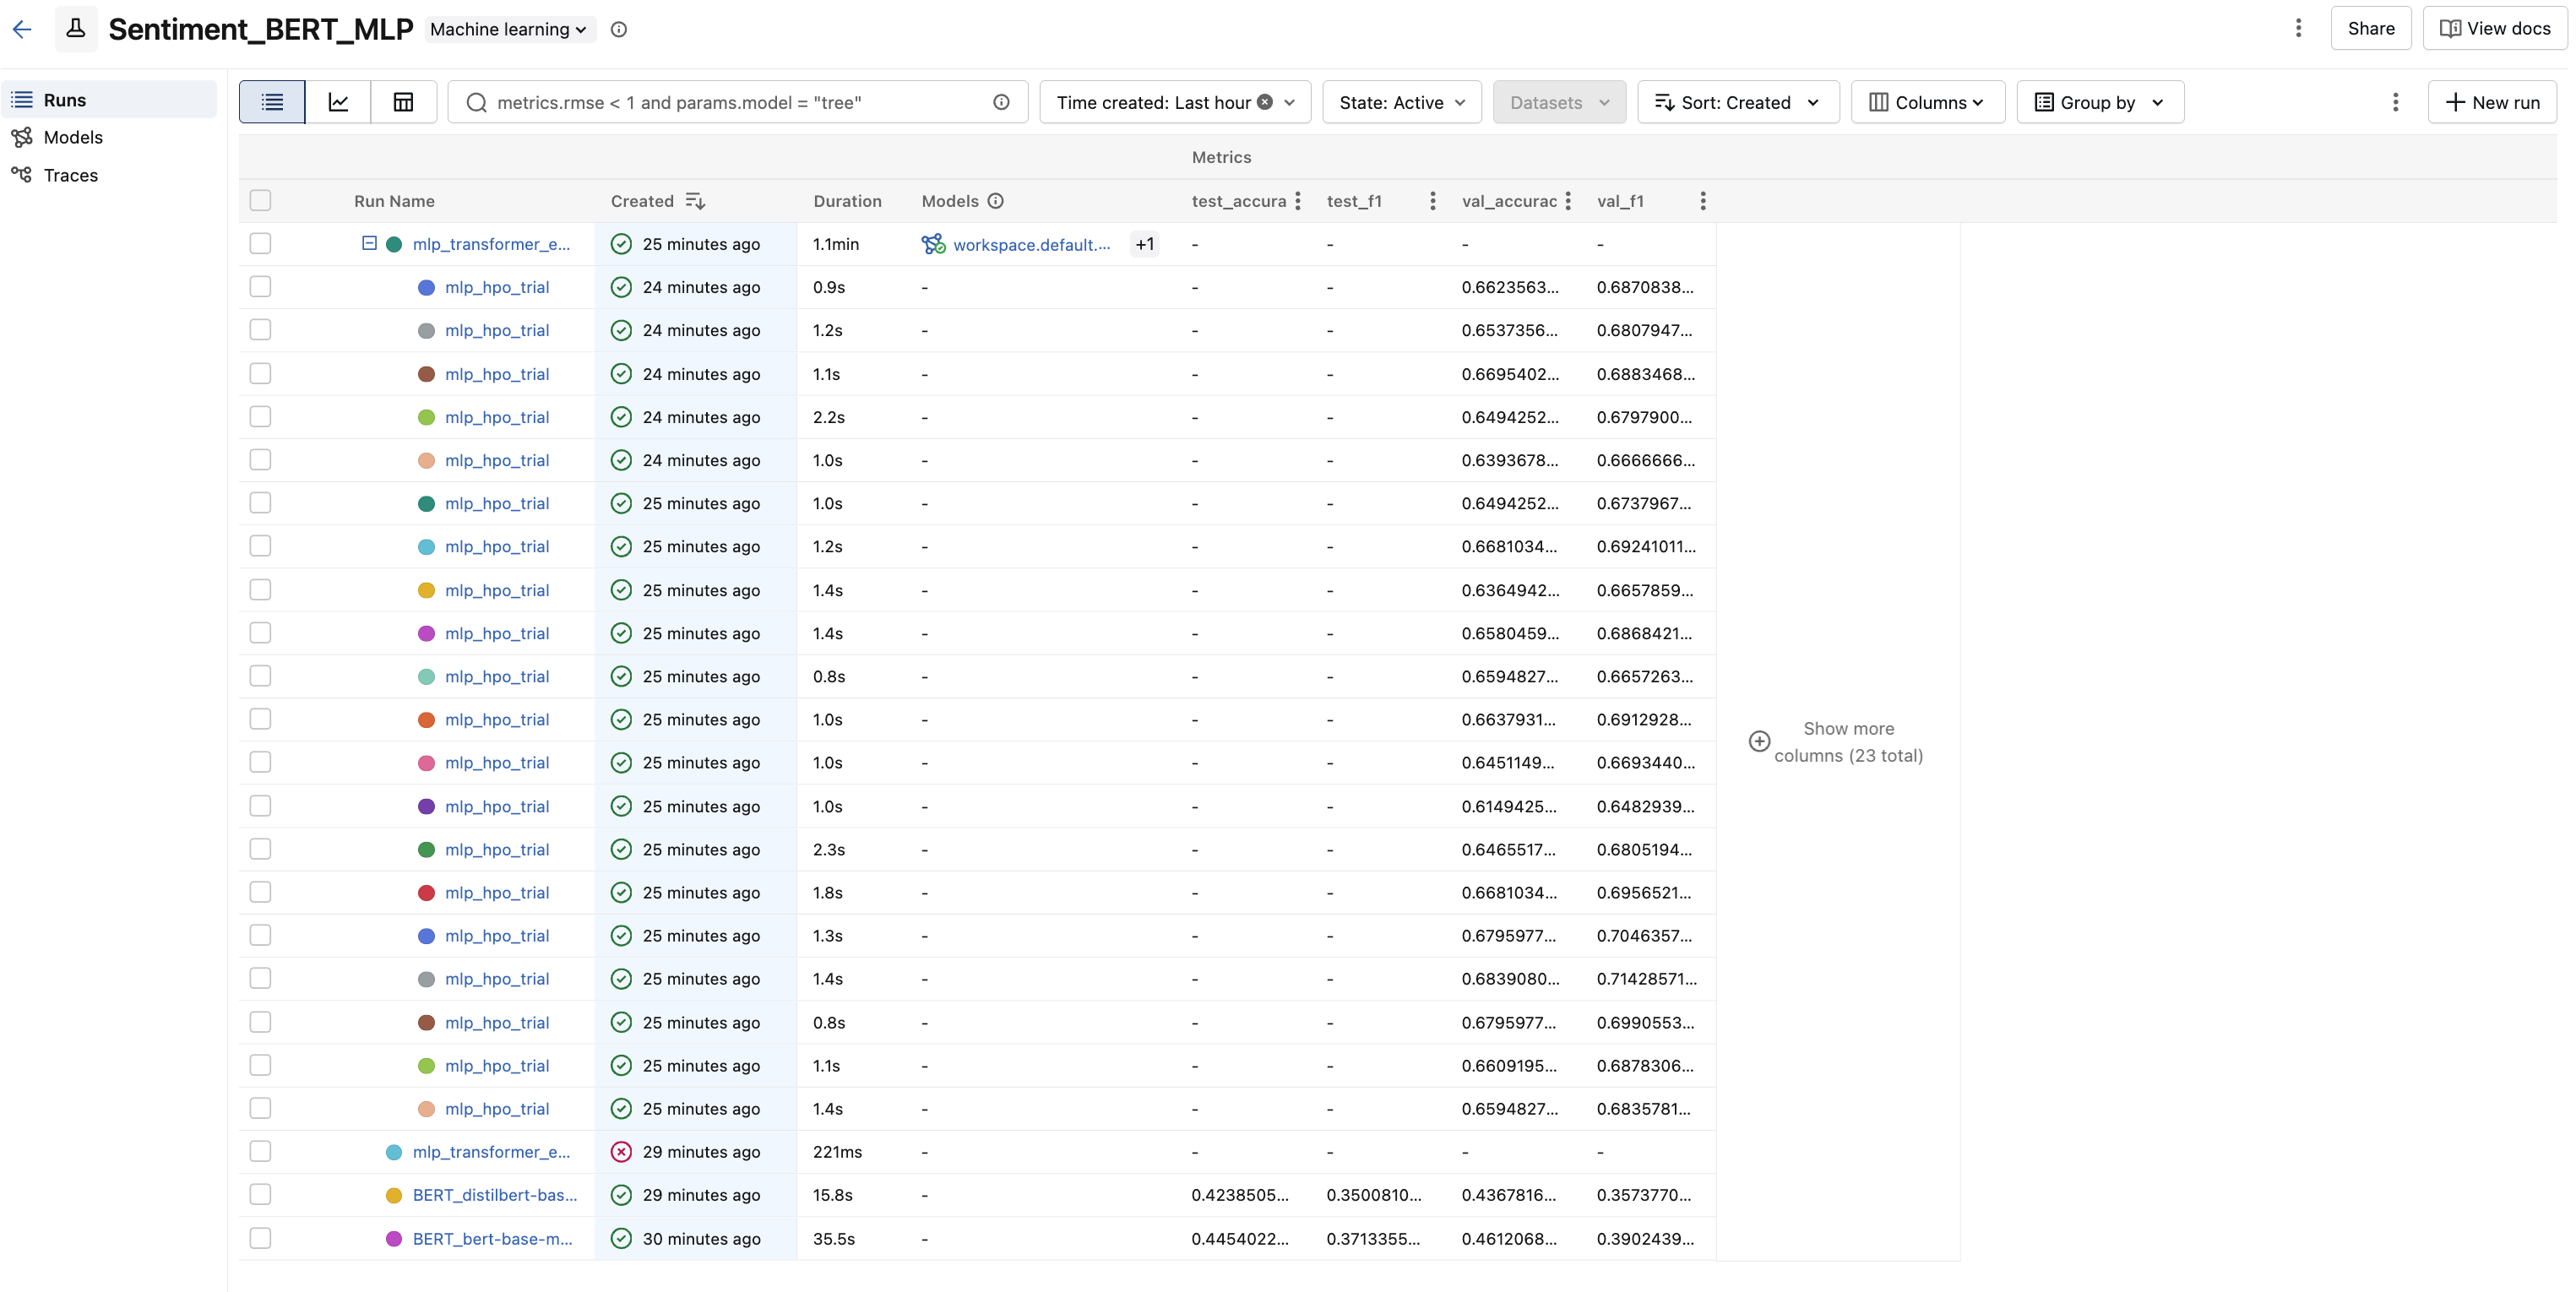

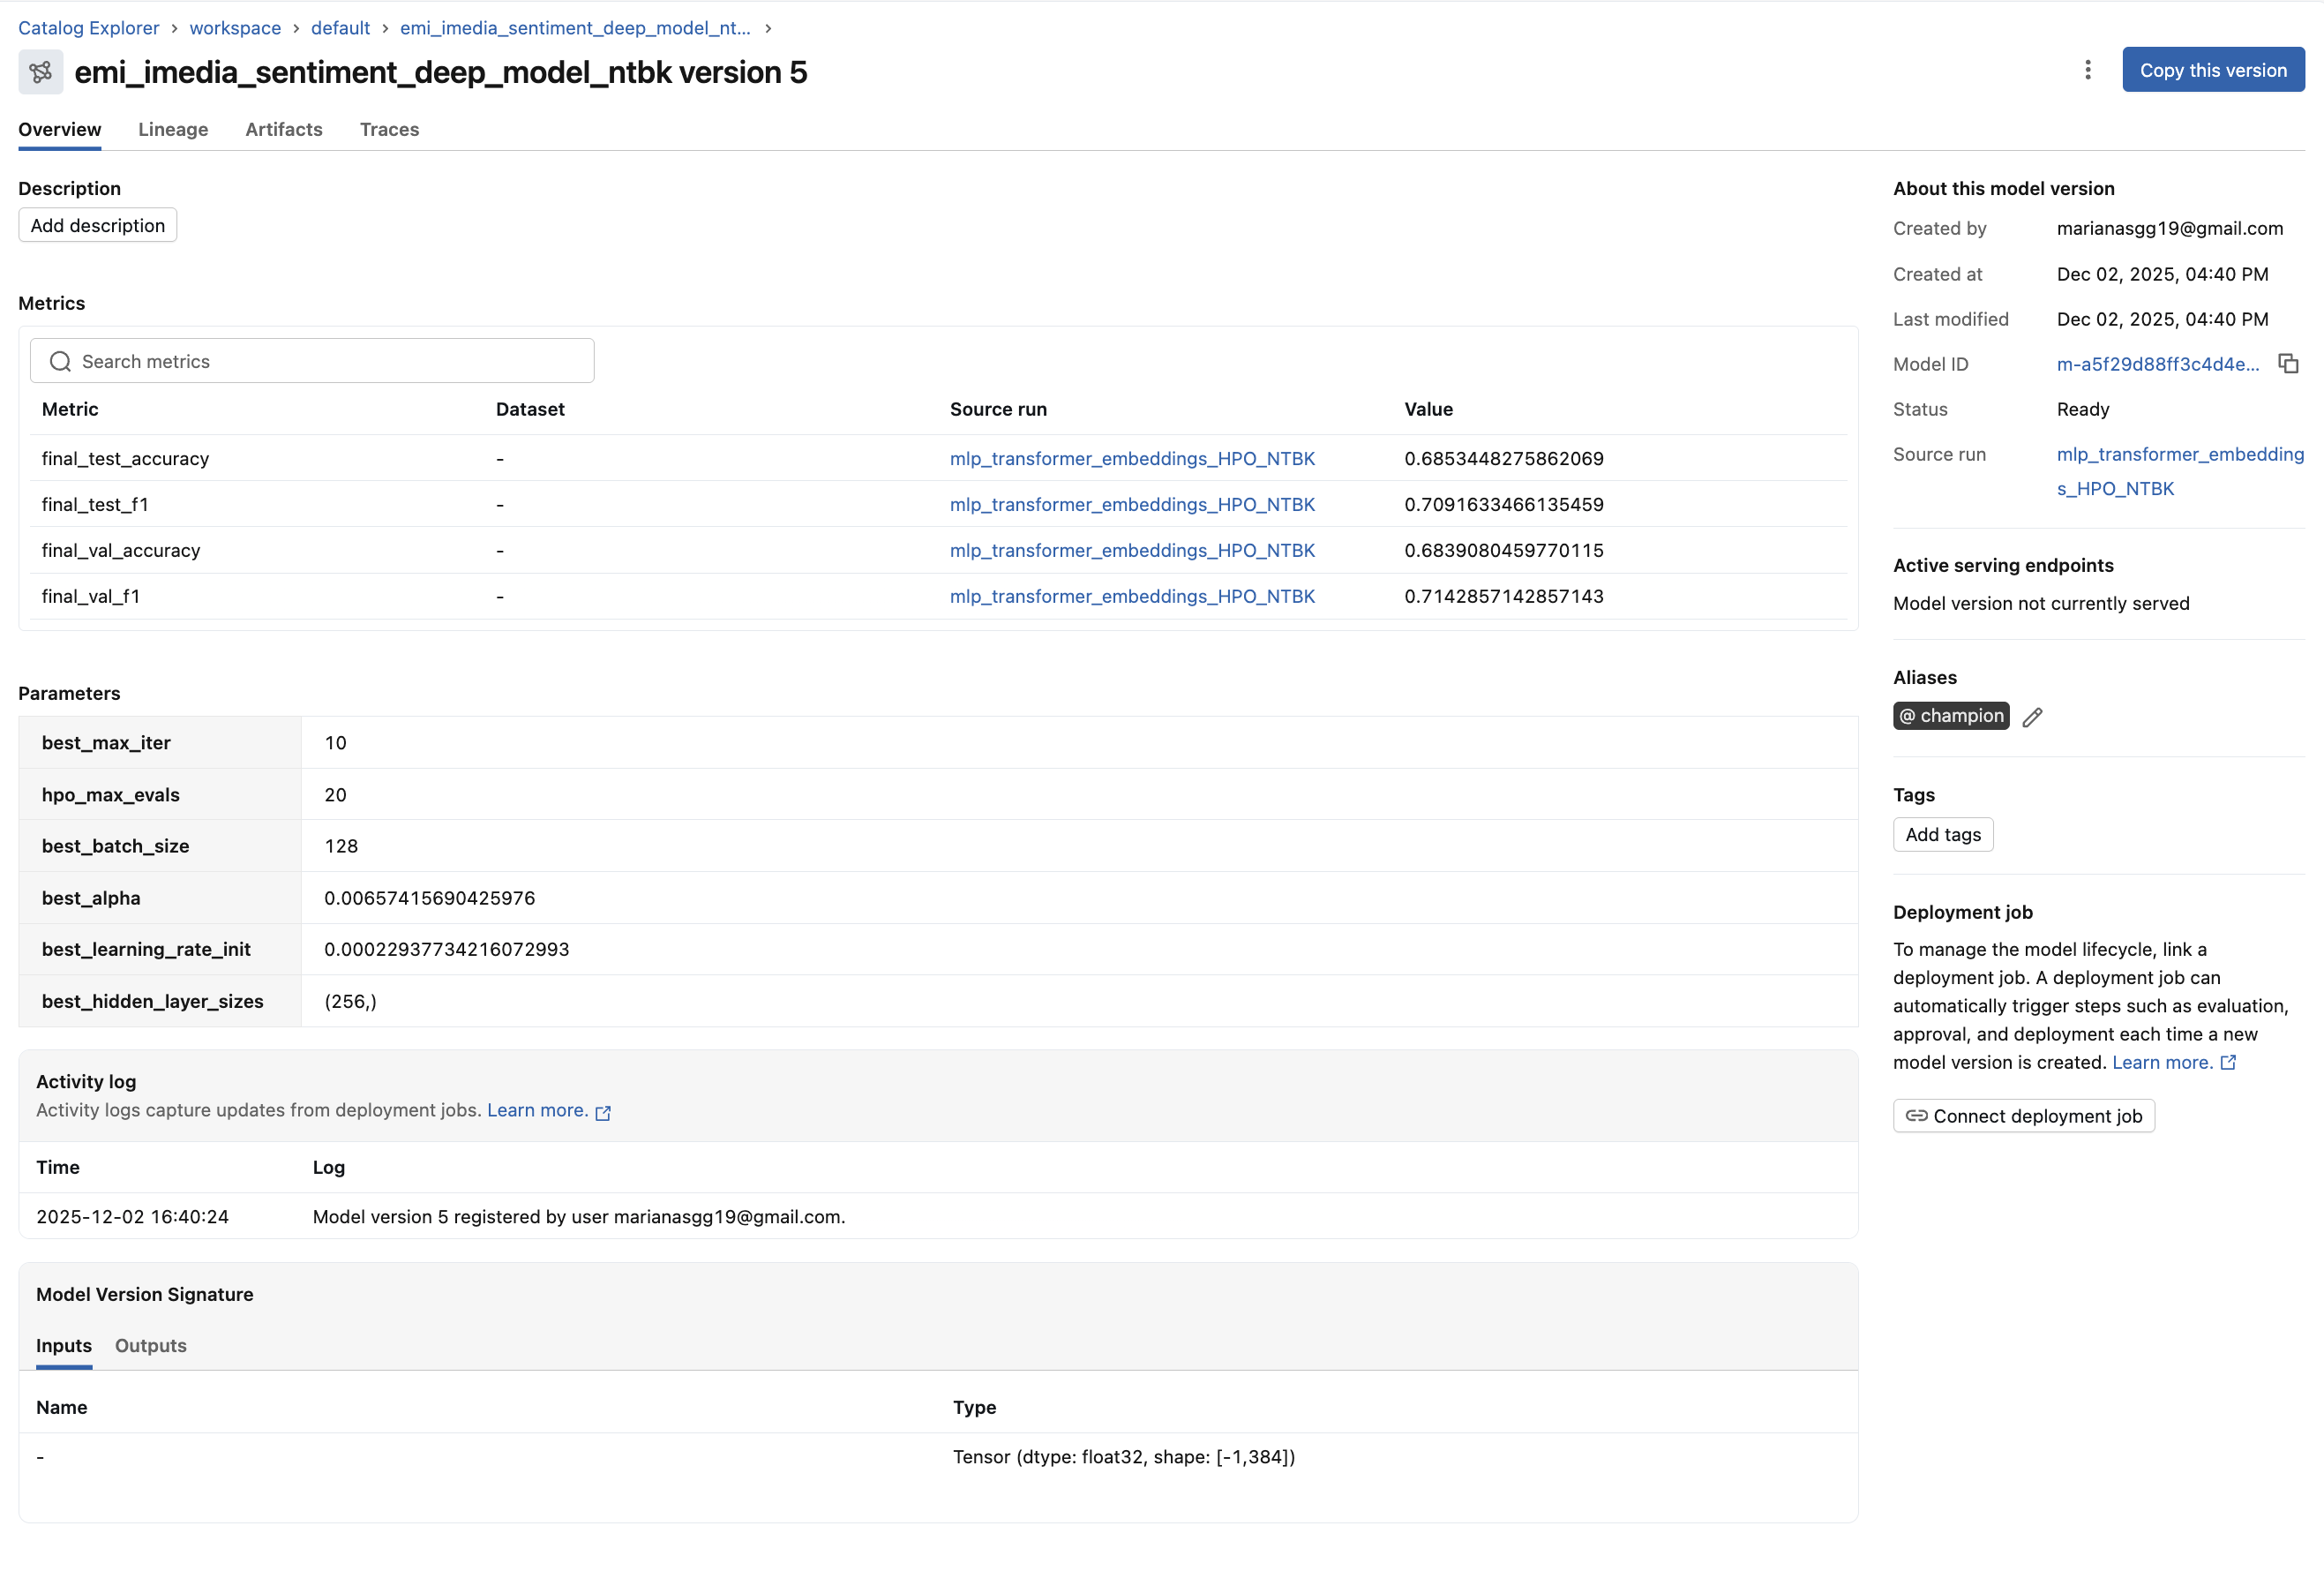